# Compare regular and stable PCP

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from numpy.linalg import inv, eig, pinv
from scipy import linalg
from scipy import pi, multiply, power, tanh, exp, cosh
from scipy import random

In [2]:
import tensorly as tl  # import this to help plotting

Using numpy backend.


## Load MVBS data

In [3]:
MVBS_path = '../sample_data'
MVBS_fname = '20150817-20151017_MVBS.h5'

In [4]:
# Reading 2-month sonar time series
import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),"r")
MVBS = np.array(f['MVBS'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_time = np.array(f['ping_time'])
f.close()

In [5]:
ping_per_day_mvbs = 144

In [6]:
# converting to linear domain
mvbs = 10**(MVBS[:,1:-2,:]/10)  # 62-day stretch
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

Note that here all lower case variables (e.g., `mvbs`, `mvbs_long`) are in the linear domain and all upper case variables (e.g., `MVBS`) are in the log domain.

## Compare regular and stable PCP

In [7]:
# For whatever reason I wasn't able to directly import rpca and spcp 
# ... as described in https://github.com/ShunChi100/RobustPCA/tree/master/RobustPCA
# ... so here I copied the .py files and the import directly as a module.
# Need to fix this at some point.
import rpca as rpca
import spcp as spcp


 install fbpca first: `pip install fbpca` 


 install fbpca first: `pip install fbpca` 



First let's run regular PCP (robust PCA).

In [8]:
M = 10*np.log10(mvbs_long)

In [9]:
rpca_m = rpca.RobustPCA()

In [10]:
rpca_m.fit(M)
L_rpca = rpca_m.get_low_rank()
S_rpca = rpca_m.get_sparse()

Not converged!
Total error: 15.969658, allowed tolerance: 0.000001


And then run stable PCP.

In [11]:
spcp_m = spcp.StablePCP(max_iter=200)

In [12]:
spcp_m.fit(M)
L_spcp = spcp_m.get_low_rank()
S_spcp = spcp_m.get_sparse()

Not converged within 200 iterations!
Total error: 0.097429, allowed tolerance: 0.000001


Now let's do some reshaping and then compare the low-rank components from regular and stable PCP.

In [13]:
len_1freq = ping_per_day_mvbs*37
idx_vec = np.arange(len_1freq)

L_rpca_freq1 = L_rpca[:,:len_1freq]
L_spcp_freq1 = L_spcp[:,:len_1freq]

S_rpca_freq1 = S_rpca[:,:len_1freq]
S_spcp_freq1 = S_spcp[:,:len_1freq]

### Compare the LOW-RANK components from regular and stable PCP

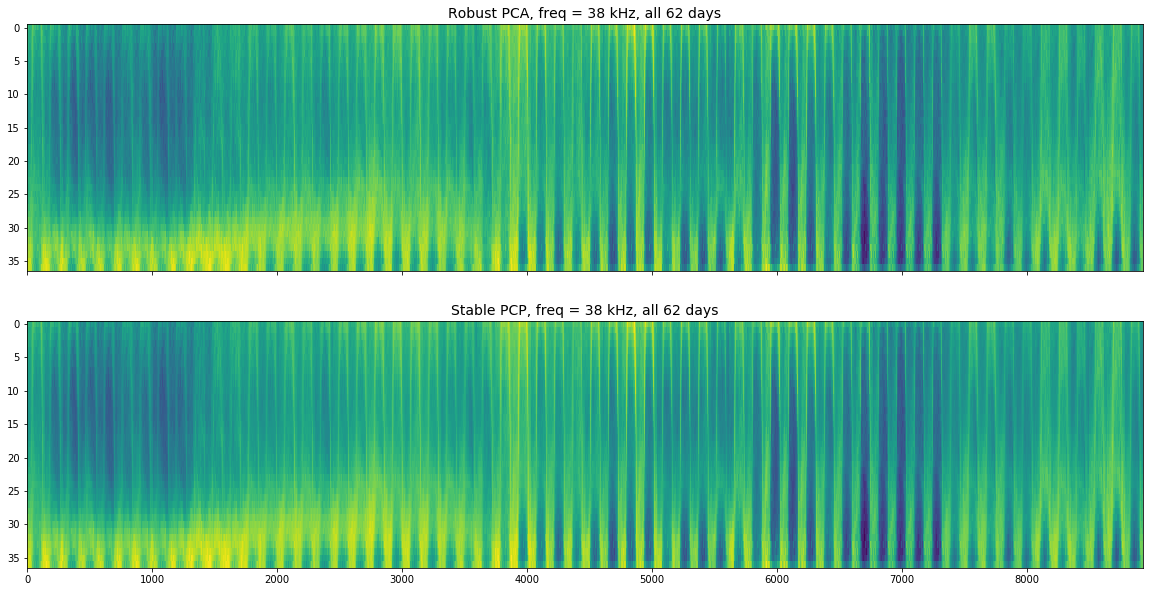

In [14]:
# All 62 days
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('Robust PCA, freq = 38 kHz, all 62 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('Stable PCP, freq = 38 kHz, all 62 days', fontsize=14)

plt.show()

It's actually pretty difficult to see if there's any difference in the above plots. So let's zoom in to the first 10 days to check out the details.

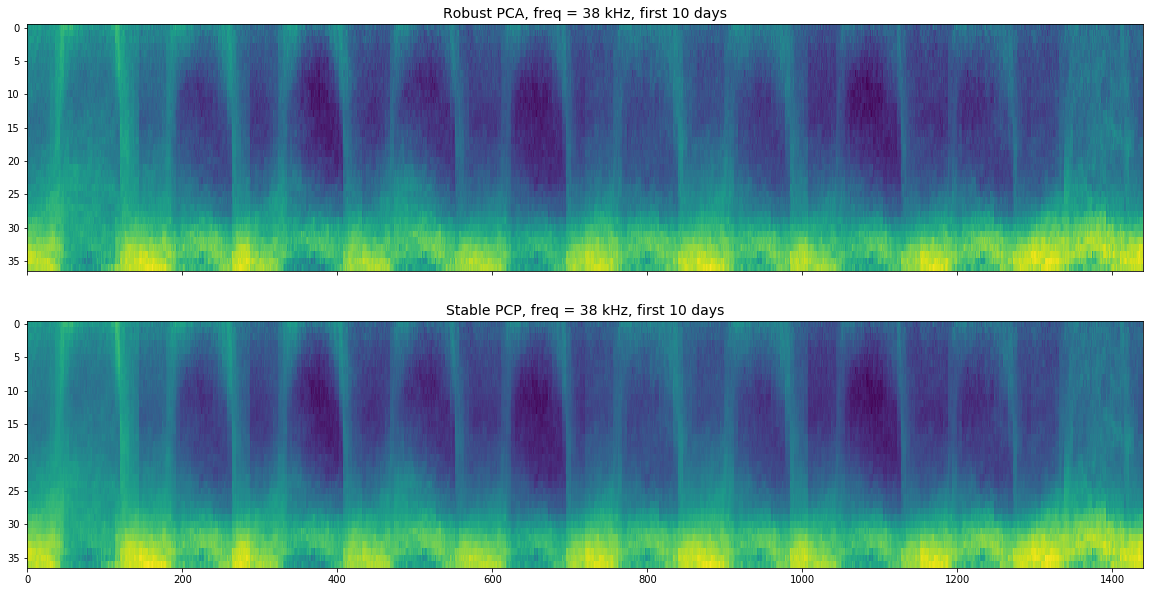

In [15]:
# The first 10 days
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), 
           aspect='auto')
plt.title('Robust PCA, freq = 38 kHz, first 10 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), 
           aspect='auto')
plt.title('Stable PCP, freq = 38 kHz, first 10 days', fontsize=14)

plt.show()

There still seem to be very little difference between the low-rank components from the two formulations, but we can plot out the difference explicitly below:

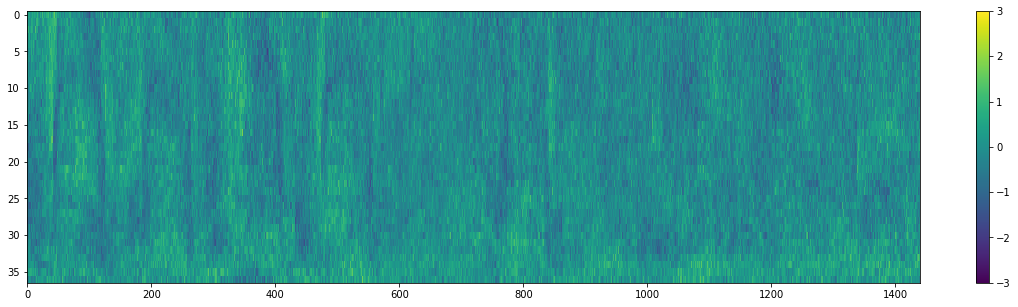

In [16]:
plt.figure(figsize=(20,5))
plt.imshow(tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)-
           tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.colorbar()
plt.show()

### Compare the SPARSE components from regular and stable PCP

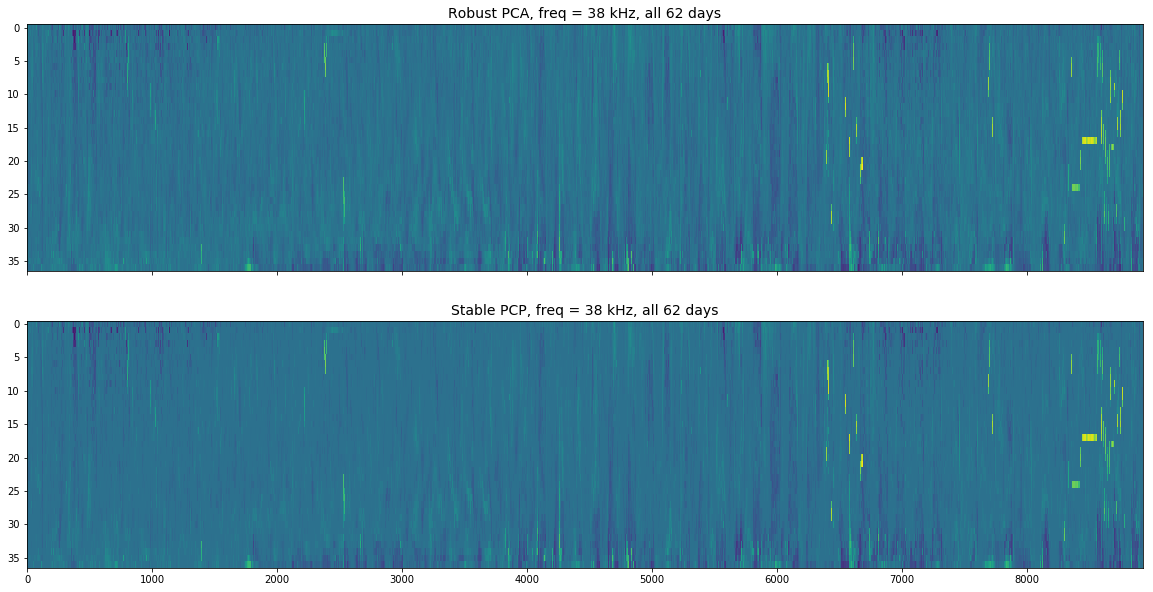

In [17]:
# All 62 days
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('Robust PCA, freq = 38 kHz, all 62 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('Stable PCP, freq = 38 kHz, all 62 days', fontsize=14)

plt.show()

It's actually pretty difficult to see if there's any difference in the above plots. So let's zoom in to the first 10 days to check out the details.

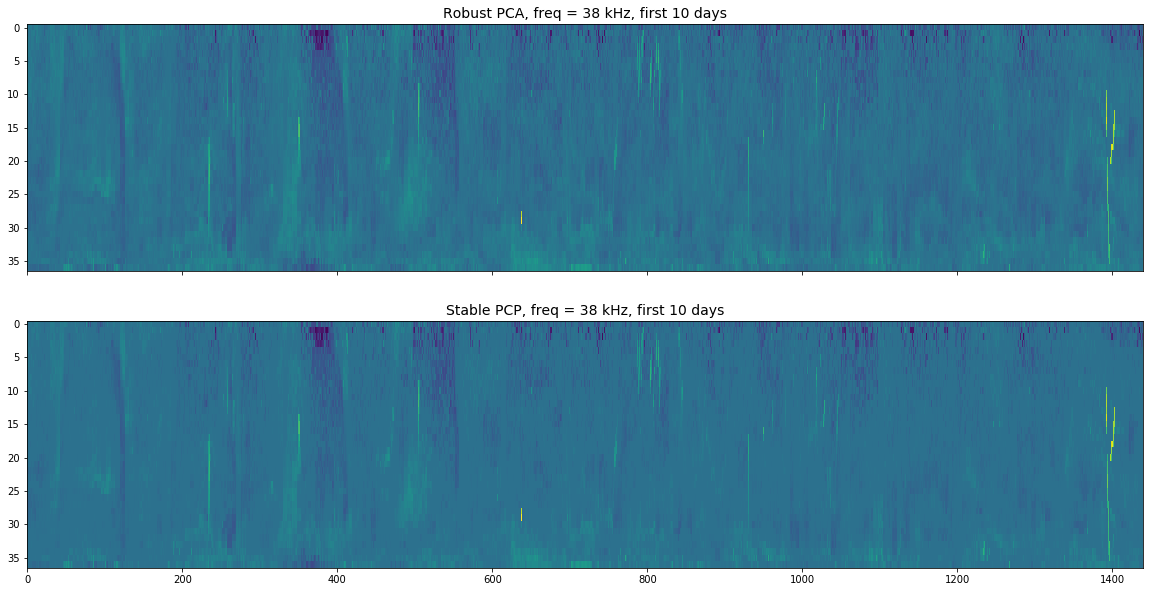

In [18]:
# The first 10 days
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), 
           aspect='auto')
plt.title('Robust PCA, freq = 38 kHz, first 10 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), 
           aspect='auto')
plt.title('Stable PCP, freq = 38 kHz, first 10 days', fontsize=14)

plt.show()

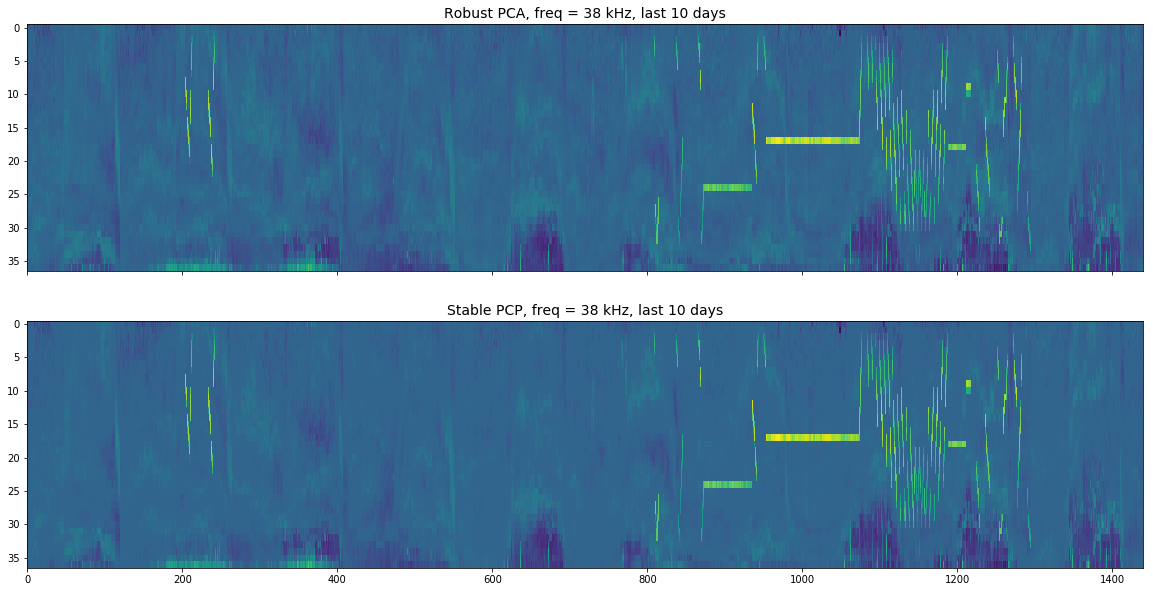

In [27]:
# The last 10 days
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[-10:,:]),mode=2), 
           aspect='auto')
plt.title('Robust PCA, freq = 38 kHz, last 10 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[-10:,:]),mode=2), 
           aspect='auto')
plt.title('Stable PCP, freq = 38 kHz, last 10 days', fontsize=14)

plt.show()

There seems to be very little difference between the sparse components from the two formulations, although the bottom plot seems less rough. We can plot out the difference explicitly below:

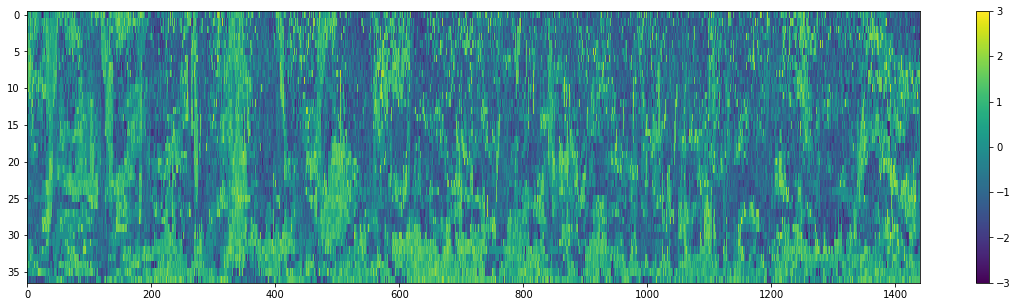

In [19]:
plt.figure(figsize=(20,5))
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)-
           tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.colorbar()
plt.show()

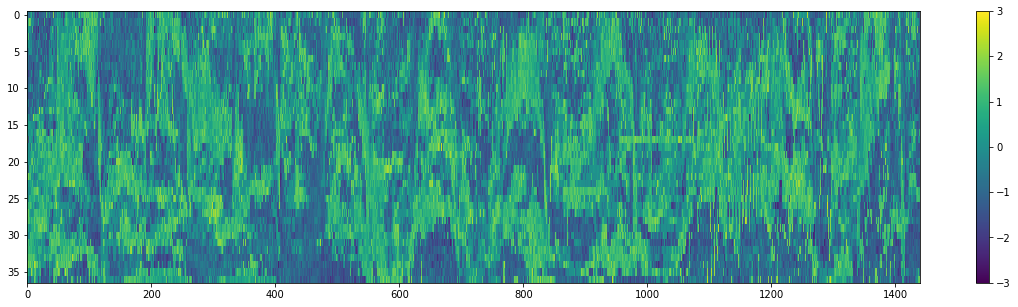

In [28]:
plt.figure(figsize=(20,5))
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[-10:,:]),mode=2)-
           tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[-10:,:]),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.colorbar()
plt.show()

The difference between the two sparse components seem more patchy compared to the difference in the two low-rank components. We need to resolve if more "noise" got pushed to the low-rank or sparse component when we switch from robust PCA to stable PCP.

### Compare the DIFFERENCE between low-rank and sparse components from the two formulations

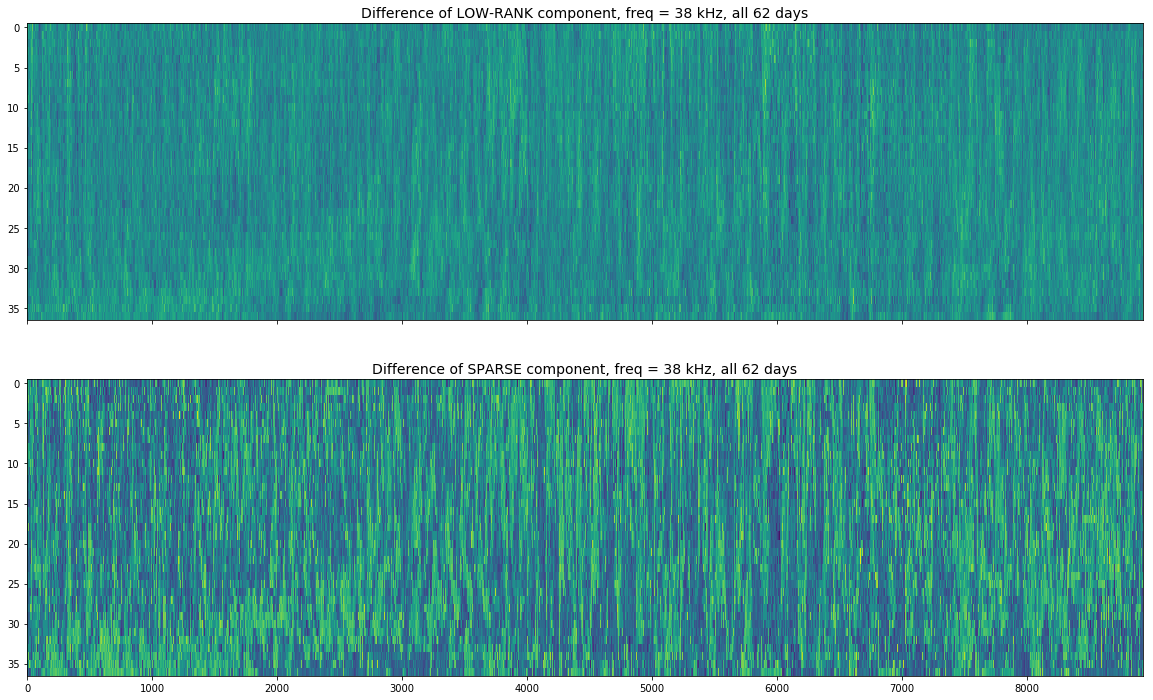

In [20]:
# The whole 62 days
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)-
           tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.title('Difference of LOW-RANK component, freq = 38 kHz, all 62 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)-
           tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.title('Difference of SPARSE component, freq = 38 kHz, all 62 days', fontsize=14)

plt.show()

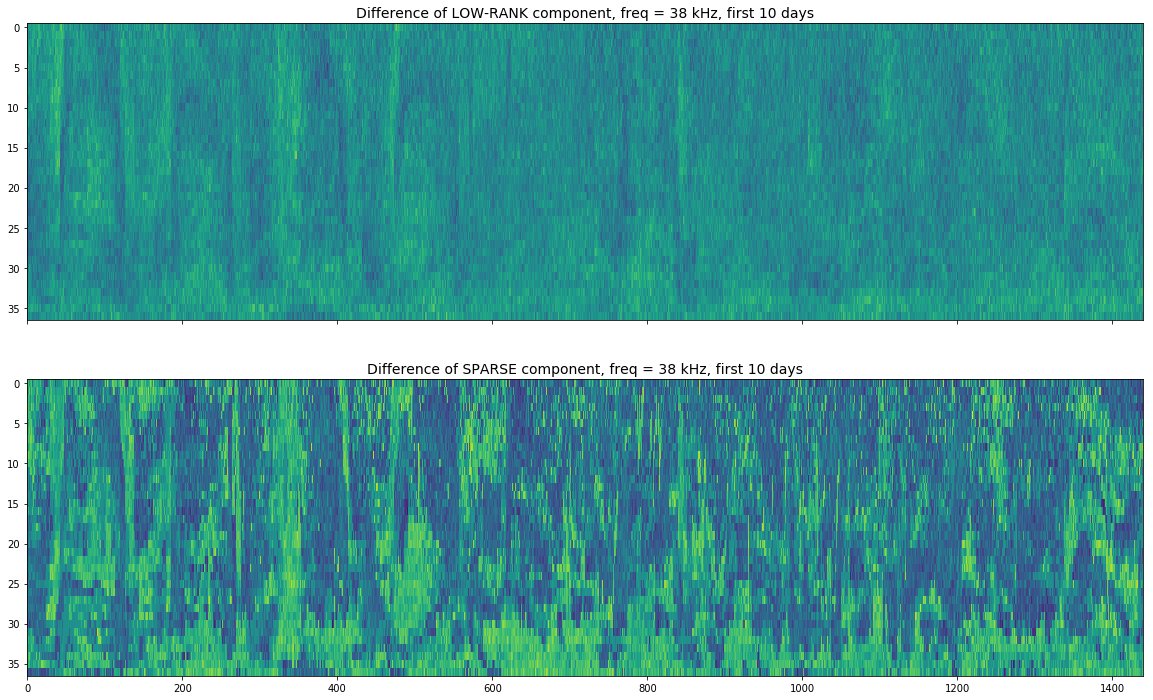

In [21]:
# The first 10 days
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)-
           tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.title('Difference of LOW-RANK component, freq = 38 kHz, first 10 days', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)-
           tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2), aspect='auto',
          vmin=-3, vmax=3)
plt.title('Difference of SPARSE component, freq = 38 kHz, first 10 days', fontsize=14)

plt.show()

In [23]:
S_diff = tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)-\
           tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)
L_diff = tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)-\
           tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()[:10,:]),mode=2)

In [24]:
S_diff.std()

0.99588406621919834

In [25]:
L_diff.std()

0.43108165049223218

So we know that there are more difference between the sparse components than between the low-rank components, which seems to suggest that more "noise" was pushed to the sparse component.

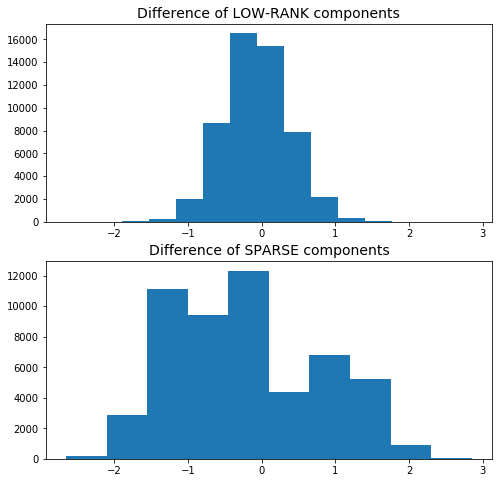

In [37]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax1.hist(L_diff.ravel())
ax1.set_title('Difference of LOW-RANK components', fontsize=14)
ax1.set_xlim(-3,3)

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.hist(S_diff.ravel())
ax2.set_title('Difference of SPARSE components', fontsize=14)

plt.show()

When we look more closely to the distribution of the differences, we can see that the low-rank component differences are more Gaussian-distributed, while the sparse component differences are more skewed toward negative values. 

In computing the difference we did `S_rpca-S_spcp`. This skew therefore means that more "stuff" got pushed to the sparse component of `spcp`.

### Check the `Z` component in `spcp`

Below we take a look at the `Z` component in `spcp` and check if the decomposition using `rpca` is indeed exact.

In [53]:
MVBS_long = 10*np.log10(mvbs_long)  # MVBS (log domain)

len_1freq = ping_per_day_mvbs*37
idx_vec = np.arange(len_1freq)

Z_rpca = tl.unfold(tl.tensor(MVBS_long[:,idx_vec].reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)-\
        tl.unfold(tl.tensor(L_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)-\
        tl.unfold(tl.tensor(S_rpca_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)

Z_spcp = tl.unfold(tl.tensor(MVBS_long[:,idx_vec].reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)-\
        tl.unfold(tl.tensor(L_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)-\
        tl.unfold(tl.tensor(S_spcp_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2)

In [54]:
Z_spcp.shape

(37, 8928)

### Z component in `rpca`

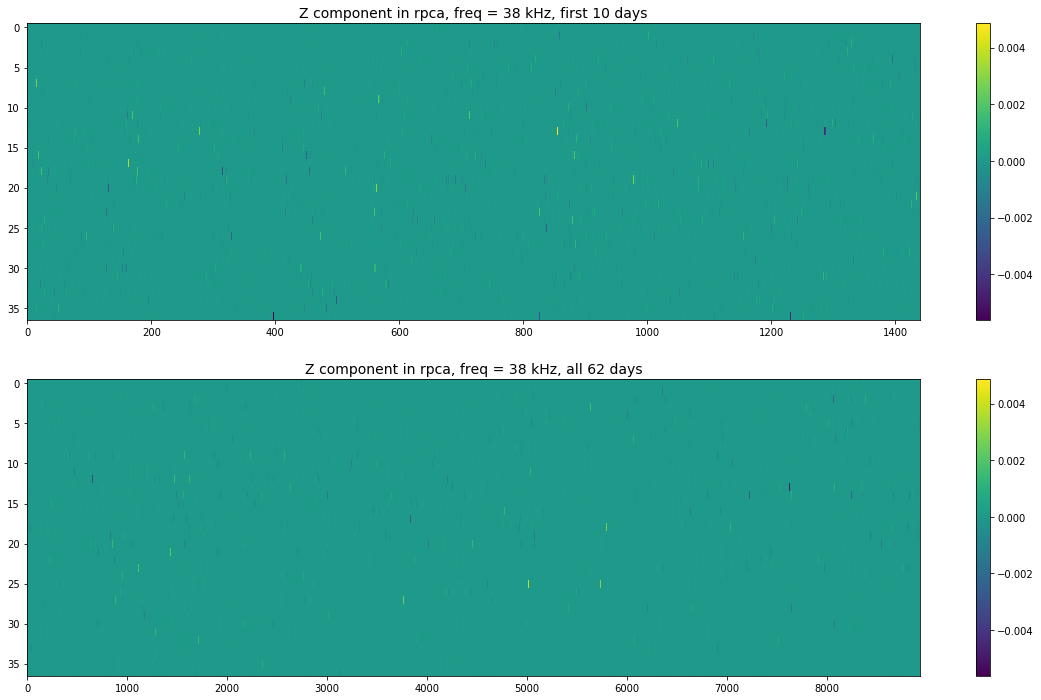

In [55]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
plt.imshow(Z_rpca[:,:ping_per_day_mvbs*10], aspect='auto')
plt.title('Z component in rpca, freq = 38 kHz, first 10 days', fontsize=14)
plt.colorbar()

ax2 = fig.add_subplot(212)
plt.imshow(Z_rpca, aspect='auto')
plt.title('Z component in rpca, freq = 38 kHz, all 62 days', fontsize=14)
plt.colorbar()

plt.show()

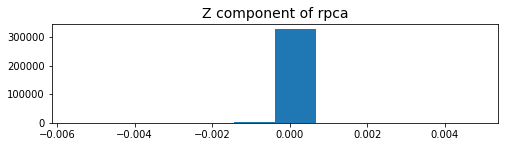

In [56]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(211)
ax1.hist(Z_rpca.ravel())
ax1.set_title('Z component of rpca', fontsize=14)
plt.show()

The results of $L+S$ is not exactly the same with the original matrix under `rpca`, but it's close.

### Z component in `spcp`

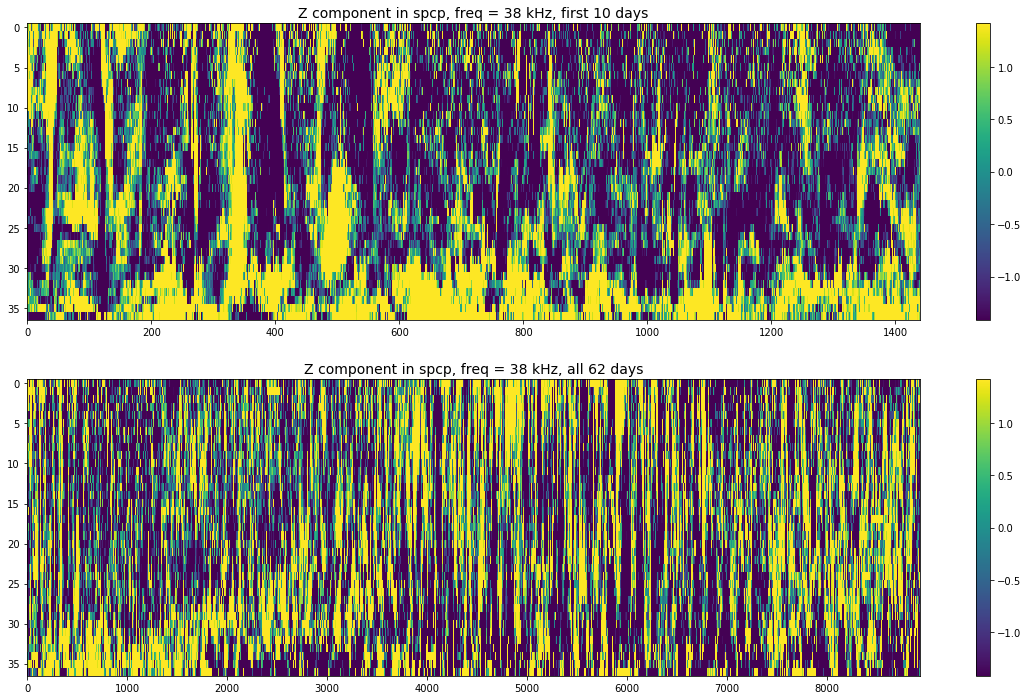

In [47]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
plt.imshow(Z_spcp[:,:ping_per_day_mvbs*10], aspect='auto')
plt.title('Z component in spcp, freq = 38 kHz, first 10 days', fontsize=14)
plt.colorbar()

ax2 = fig.add_subplot(212)
plt.imshow(Z_spcp, aspect='auto')
plt.title('Z component in spcp, freq = 38 kHz, all 62 days', fontsize=14)
plt.colorbar()

plt.show()

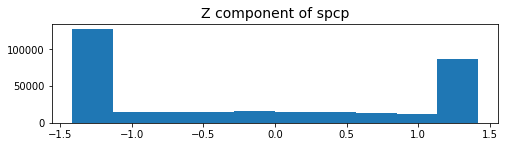

In [49]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(211)
ax1.hist(Z_spcp.ravel())
ax1.set_title('Z component of spcp', fontsize=14)
plt.show()

In [58]:
(Z_spcp.ravel().min(), Z_spcp.ravel().max())

(-1.4162876885408338, 1.4169681561923659)

Here we see a lot more "noise" in the `Z_spcp` term. Interestingly the values are skewed toward either end near $\pm$1.416. This looks like some magic number, which makes using this seems a little scary. However the computation for either of the algorithms have not converged, so we should try that again.